In [22]:
import numpy as np
import sys
import qutip as qtp 
import matplotlib.pyplot as plt
from scipy import constants
import pysqkit
from pysqkit import Qubit
import xarray
from pysqkit.util.linalg import get_mat_elem, tensor_prod
from itertools import product
from pysqkit.solvers import solvkit
from typing import List
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
import json

In [23]:
with open('../flx_transm_params.txt') as param_file:
    parameters_set = json.load(param_file)

In [24]:
#Transmon
levels_t = 3
transm = pysqkit.qubits.SimpleTransmon(
    label='T', 
    max_freq=5.0, 
    anharm=-0.3,
    dim_hilbert=levels_t
)

levels_f = 8

flx_cr = pysqkit.qubits.Fluxonium(
    label='F', 
    charge_energy=parameters_set["2"]["charge_energy_f"], 
    induct_energy=parameters_set["2"]["induct_energy_f"], 
    joseph_energy=parameters_set["2"]["joseph_energy_f"], 
)
flx_cr.diagonalize_basis(levels_f)
flx_cphase = pysqkit.qubits.Fluxonium(
    label='F', 
    charge_energy=parameters_set["0"]["charge_energy_f"], 
    induct_energy=parameters_set["0"]["induct_energy_f"], 
    joseph_energy=parameters_set["0"]["joseph_energy_f"], 
)
flx_cphase.diagonalize_basis(levels_f)

flx_dict = {"cr": flx_cr, "cphase": flx_cphase}

In [25]:
flx_transitions = [["0", "1"], ["1", "2"], ["0", "3"]]
transm_transitions = [["0", "1"], ["1", "2"]]

flx_data = {}
flx_data["cr"] = []
flx_data["cphase"] = []

for key in flx_dict.keys():
    for transition in flx_transitions:
        state_a = flx_dict[key].state(transition[0])
        state_b = flx_dict[key].state(transition[1])
        freq = np.abs(state_a[0] - state_b[0])
        charge_mat_elem = np.abs(get_mat_elem(flx_dict[key].charge_op(), state_a[1], state_b[1]))
        flx_data[key].append({"transition": transition[0] + transition[1], "freq": freq, "mat_elem": charge_mat_elem})

transm_data = []

for transition in transm_transitions:
    state_a = transm.state(transition[0])
    state_b = transm.state(transition[1])
    freq = np.abs(state_a[0] - state_b[0])
    charge_mat_elem = np.abs(get_mat_elem(transm.charge_op(), state_a[1], state_b[1]))
    transm_data.append({"transition": transition[0] + transition[1], "freq": freq, "mat_elem": charge_mat_elem})

In [28]:
def plot_mat_elem(
    flx_data: dict,
    transm_data: list,
    opt={'fs': 26, 'lw': 3.0, 'ls': 20, 'fsl':20},
    save=False
):
    fig, ax = plt.subplots(figsize=(6, 10))
    colors = ["darkblue", "firebrick", "firebrick"]
    n_flx_transition = len(flx_data["cr"])
    n_transm_transition = len(transm_data)
    xlim = 1.7
    for k in range(n_flx_transition):
        if k==0:
            ax.axhline(y=flx_data["cr"][k]["freq"], xmin=0, xmax=flx_data["cr"][k]["mat_elem"]/xlim, 
                          color=colors[1], linewidth=opt["lw"], label="Fluxonium CR")
            ax.plot(flx_data["cr"][k]["mat_elem"], flx_data["cr"][k]["freq"], marker='o', color=colors[1])
            ax.axhline(y=flx_data["cphase"][k]["freq"], xmin=0, xmax=flx_data["cphase"][k]["mat_elem"]/xlim, 
                          color=colors[2], linewidth=opt["lw"], linestyle="--", label="Fluxonium CPHASE")
            ax.plot(flx_data["cphase"][k]["mat_elem"], flx_data["cphase"][k]["freq"], marker='v', color=colors[1])
        else:
            ax.axhline(y=flx_data["cr"][k]["freq"], xmin=0, xmax=flx_data["cr"][k]["mat_elem"]/xlim, 
                          color=colors[1], linewidth=opt["lw"])
            ax.plot(flx_data["cr"][k]["mat_elem"], flx_data["cr"][k]["freq"], marker='o', color=colors[1])
            ax.axhline(y=flx_data["cphase"][k]["freq"], xmin=0, xmax=flx_data["cphase"][k]["mat_elem"]/xlim, 
                          color=colors[2], linewidth=opt["lw"], linestyle="--")
            ax.plot(flx_data["cphase"][k]["mat_elem"], flx_data["cphase"][k]["freq"], marker='v', color=colors[1])
    for k in range(n_transm_transition):
        if k==0:
            ax.axhline(y=transm_data[k]["freq"], xmin=0, xmax=transm_data[k]["mat_elem"]/xlim, 
                          color=colors[0], linewidth=opt["lw"], label="Transmon")
            ax.plot(transm_data[k]["mat_elem"], transm_data[k]["freq"], marker='D', color=colors[0])
        else:
            ax.axhline(y=transm_data[k]["freq"], xmin=0, xmax=transm_data[k]["mat_elem"]/xlim, 
                          color=colors[0], linewidth=opt["lw"])
            ax.plot(transm_data[k]["mat_elem"], transm_data[k]["freq"], marker='D', color=colors[0])
            
    ax.set_xlabel('$\\langle k | q_{\\alpha} | l \\rangle$', fontsize=opt["fs"])
    ax.set_ylabel('$\\omega_{\\alpha, kl}/2 \pi \, (\\mathrm{GHz})$', fontsize=opt["fs"])
    x_ticks = [x*0.2 for x in range(9)]
    x_ticks_latex = ['$0.0$', '$0.2$', '$0.4$', '$0.6$', '$0.8$', '$1.0$', '$1.2$', '$1.4$', '$1.6$']
    plt.xticks(x_ticks, x_ticks_latex)
    y_ticks = [x*1 for x in range(8)]
    y_ticks_latex = ['$0.0$', '$1.0$', '$2.0$', '$3.0$', '$4.0$', '$5.0$', '$6.0$', '$7.0$']
    plt.yticks(y_ticks, y_ticks_latex)
    ax.tick_params(axis='both', labelsize=opt["ls"])
    plt.legend(loc='lower right', fontsize=opt["fsl"])
    
    ax.set_xlim([0, xlim])
    
    if save:
        plt.savefig("mat_elem_bar.svg")
    
    
    plt.show()
    
    

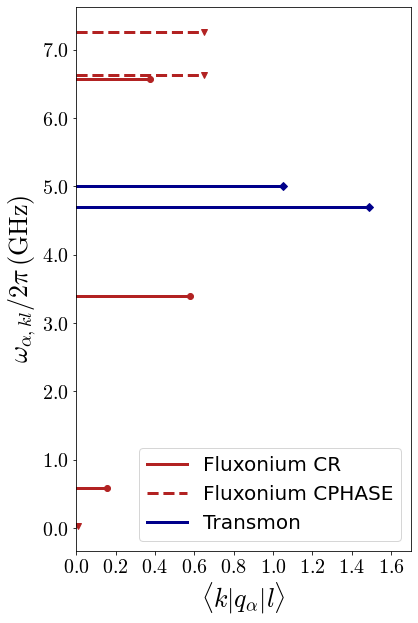

In [31]:
plot_mat_elem(flx_data, transm_data, save=True)

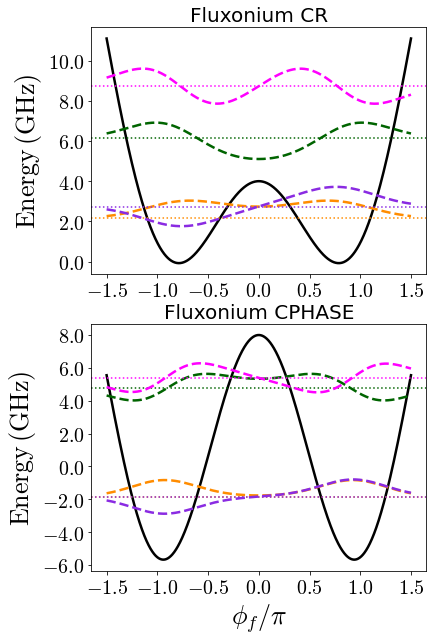

In [32]:
def plot_wave_function(
    opt={'fs': 26, 'lw': 2.5, 'ls': 20, 'fsl':20},
    save=False
):
    colors = ["black", "darkorange", "blueviolet", "darkgreen", "magenta"]
    flx_cr = pysqkit.qubits.Fluxonium(
    label='F', 
    charge_energy=parameters_set["2"]["charge_energy_f"], 
    induct_energy=parameters_set["2"]["induct_energy_f"], 
    joseph_energy=parameters_set["2"]["joseph_energy_f"], 
    )
    flx_cphase = pysqkit.qubits.Fluxonium(
        label='F', 
        charge_energy=parameters_set["0"]["charge_energy_f"], 
        induct_energy=parameters_set["0"]["induct_energy_f"], 
        joseph_energy=parameters_set["0"]["joseph_energy_f"], 
    )
    phi = np.linspace(-3/2*np.pi, 3/2*np.pi, 1000)
    fig, ax = plt.subplots(2, figsize=(6, 10))
    levels = [0, 1, 2, 3]
    wf_cr = flx_cr.wave_function(phi, levels=levels)
    wf_cphase = flx_cphase.wave_function(phi, levels=levels)
    styles = ["--", "--", "--", "--"]
    ax[0].plot(phi/np.pi, np.array(wf_cr["potential"]), color=colors[0], linewidth=opt["lw"], linestyle="-")
    ax[1].plot(phi/np.pi, np.array(wf_cphase["potential"]), color=colors[0], linewidth=opt["lw"], linestyle="-")
    for lev in levels:
        ax[0].plot(phi/np.pi, np.array(wf_cr["energy"][lev]) + 2*np.array(wf_cr["wave_func"][lev]), 
                   linewidth=opt["lw"], linestyle=styles[lev], color=colors[lev + 1])
        ax[0].axhline(y=np.array(wf_cr["energy"][lev]), linestyle=":", color=colors[lev + 1])
        ax[1].plot(phi/np.pi, np.array(wf_cphase["energy"][lev]) + 2*np.array(wf_cphase["wave_func"][lev]), 
                   linewidth=opt["lw"], linestyle=styles[lev], color=colors[lev + 1])
        ax[1].axhline(y=np.array(wf_cphase["energy"][lev]), linestyle=":", color=colors[lev + 1])
    ax[1].set_xlabel('$\\phi_f/\pi$', fontsize=opt["fs"])
    ax[0].set_ylabel('$\\mathrm{Energy}\, (\\mathrm{GHz})$', fontsize=opt["fs"])
    ax[1].set_ylabel('$\\mathrm{Energy}\, (\\mathrm{GHz})$', fontsize=opt["fs"])
    x_ticks = [-1.5 + 0.5*x for x in range(7)]
    x_ticks_latex = ['$-1.5$', '$-1.0$', '$-0.5$', '$0.0$', '$0.5$', '$1.0$', '$1.5$']
    y_ticks_cr = [2.0*y for y in range(6)]
    y_ticks_cr_latex = ['$0.0$', '$2.0$', '$4.0$', '$6.0$', '$8.0$', '$10.0$'] 
    ax[0].set_xticks(x_ticks)
    ax[0].set_xticklabels(x_ticks_latex)
    ax[0].set_yticks(y_ticks_cr)
    ax[0].set_yticklabels(y_ticks_cr_latex)
    ax[0].tick_params(axis='both', labelsize=opt["ls"])
    ax[0].set_title("Fluxonium CR", fontsize=opt["fsl"])
    y_ticks_cphase = [-6.0 + 2.0*y for y in range(8)]
    y_ticks_cphase_latex = ['$-6.0$', '$-4.0$', '$-2.0$', '$0.0$', '$2.0$', '$4.0$', '$6.0$', '$8.0$'] 
    ax[1].set_xticks(x_ticks)
    ax[1].set_xticklabels(x_ticks_latex)
    ax[1].set_yticks(y_ticks_cphase)
    ax[1].set_yticklabels(y_ticks_cphase_latex)
    ax[1].tick_params(axis='both', labelsize=opt["ls"])
    ax[1].set_title("Fluxonium CPHASE", fontsize=opt["fsl"])
#     plt.subplots_adjust(left=0.0,
#                     bottom=0.0, 
#                     right=1.0, 
#                     top=1.0, 
#                     wspace=0.0, 
#                     hspace=0.25)
    if save:
        plt.savefig("wf.svg")
    plt.show()

plot_wave_function(save=True)
    
    